In [1]:
#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
#from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 
import cmocean
import scipy
import seaborn as sns

import sys
sys.path.append('../')
import utils
import plotting

import difflib 

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

Census data through: https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html Annual County resident Population Estimates by Age, Sex, Race and Hispanic Origin: April 1, 2010- July 1, 2019 (CC-EST2019-ALLDATA)

In [2]:
#import dataset
df = pd.read_csv('./final_data/df_pm_o3_county_pop.csv', index_col = 0)

In [3]:
df['County_State'] = df['County_State'].str.lower()
df['StateName'] = df['StateName'].str.lower()
df['CountyName'] = df['CountyName'].str.lower()

In [4]:
census_df = pd.read_csv('final_data/cc-est2019-alldata.csv',engine='python',encoding='latin1')

In [5]:
census_df['CTYNAME'] = census_df['CTYNAME'].str.replace(' Parish', '')
census_df['CTYNAME'] = census_df['CTYNAME'].str.replace(' County', '')
census_df['CTYNAME'] = census_df['CTYNAME'].str.replace(' city', '')

df['County_State'] = df['County_State'].str.replace(' city', '')
df['CountyName'] = df['CountyName'].str.replace(' city', '')

In [6]:
census_df['CTYNAME'] = census_df['CTYNAME'].str.lower()
census_df['STNAME'] = census_df['STNAME'].str.lower()


In [7]:
census_df = census_df[census_df.STNAME.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]
census_df = census_df.loc[census_df['YEAR'] == 9] #select for the 2016 population estimate (see https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf for detail)
census_df = census_df.loc[census_df['AGEGRP'] == 0] #select for the total population estimate (see https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf for detail)


In [8]:
census_df.loc[(census_df['CTYNAME'] == 'richmond')&(census_df['COUNTY'] == 159), 'CTYNAME'] = 'richmond city' #city
census_df.loc[(census_df['CTYNAME'] == 'richmond')&(census_df['COUNTY'] == 760), 'CTYNAME'] = 'richmond county'


census_df.loc[(census_df['CTYNAME'] == 'baltimore')&(census_df['COUNTY'] == 510), 'CTYNAME'] = 'baltimore city'
census_df.loc[(census_df['CTYNAME'] == 'baltimore')&(census_df['COUNTY'] == 5), 'CTYNAME'] = 'baltimore county'

census_df.loc[(census_df['CTYNAME'] == 'st. louis')&(census_df['COUNTY'] == 510), 'CTYNAME'] = 'st. louis city'
census_df.loc[(census_df['CTYNAME'] == 'st. louis')&(census_df['COUNTY'] == 189), 'CTYNAME'] = 'st. louis county'

In [9]:
census_df['County_State'] = census_df['CTYNAME'] + ', ' + census_df['STNAME']

In [10]:
poll_df = df[df.StateName.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]


In [11]:
#find dif between two lists:
for cs in list(set(census_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


In [12]:
for cs in list(set(poll_df['County_State']).difference(census_df['County_State'])):
    print(cs, census_df.loc[census_df['County_State'] == cs]['County_State'].values)
    


In [13]:
combined_df = census_df.groupby('County_State').sum().merge(poll_df.groupby('County_State').mean(), left_index = True, right_index=True)
combined_df = combined_df.drop(columns = {'AGEGRP','STATE','COUNTY','YEAR','SUMLEV','COUNTYNS'})

In [14]:
combined_df['geometry'] = geopandas.GeoSeries.from_wkt(poll_df.groupby('County_State').first()['geometry_county'])

In [15]:
#create geo dataframe
geo_df = geopandas.GeoDataFrame(combined_df, geometry='geometry')
combined_df = geo_df.copy()

In [16]:
combined_df['American Indian or Alaska Native'] = combined_df['IA_MALE']+combined_df['IA_FEMALE']
combined_df['White'] = combined_df['WA_MALE']+combined_df['WA_FEMALE']
combined_df['Black or African American'] = combined_df['BA_MALE']+combined_df['BA_FEMALE']
combined_df['Asian or Pacific Islander'] = combined_df['NA_MALE']+combined_df['NA_FEMALE'] + combined_df['AA_MALE']+combined_df['AA_FEMALE'] 
combined_df['Hispanic or Latino'] = combined_df['H_MALE']+combined_df['H_FEMALE']

## Beta calculations for PM and Ozone

RR from Di et al. 
ΔM≃β_LL×I_OBS×(Δχ×p_aff )   

In [17]:
#mortality data from IHME GBD 2017
obs_mortality = pd.read_csv('../../health_data/global_burden_disease_2017_data/IHME-GBD_2017_DATA-2c4a32b7-1.csv')
obs_mortality = obs_mortality.drop([1,2,3,4,5])

In [18]:
mortality0 = obs_mortality['val']/combined_df['TOT_POP'].sum() #calculate our initial mortality rate


In [19]:
delta_chi = 10 #ugm-3
RR_pm = {'low':1.071 , 'mean':1.073, 'high': 1.075} 
RR_o3 = {'low':1.01 , 'mean':1.02, 'high': 1.04} #
β_o3 = {}
β_pm = {}
for ids in ['low','mean','high']:
    β_o3[ids]= np.log(RR_o3[ids])/delta_chi
    β_pm[ids]= np.log(RR_pm[ids])/delta_chi

In [20]:
for sub in ['mean', 'low', 'high']:
    for run in ['nonuc','nonuc_coal']:
        combined_df[f'Δmortality_PM_{sub}_{run}'] =  combined_df[f'PM25_{run}']* combined_df['TOT_POP'] * (mortality0 * β_pm[sub]).values
        combined_df[f'Δmortality_O3_{sub}_{run}'] =  combined_df[f'O3_{run}']* combined_df['TOT_POP'] * (mortality0 * β_o3[sub]).values



In [21]:
for sub in ['mean', 'low', 'high']:
    for run in ['nonuc','nonuc_coal']:
        combined_df[f'Δmortality_PM_{sub}_{run}_per1mil'] = combined_df[f'Δmortality_PM_{sub}_{run}']/combined_df[f'TOT_POP']*1e6
        combined_df[f'Δmortality_O3_{sub}_{run}_per1mil'] = combined_df[f'Δmortality_O3_{sub}_{run}']/combined_df[f'TOT_POP']*1e6

## Average Exposure by Race and Ethnicity

Although we have more data specificity in the census, we'll just be looking at what we can compare to the WONDER data

In [30]:
for poll in ['PM25_nonuc','PM25_nonuc_coal','O3_nonuc','O3_nonuc_coal']:
    print('\n', poll, '\n')
    for re in ['Black or African American', 'Asian or Pacific Islander',
        'Hispanic or Latino',
        'White','American Indian or Alaska Native']:
        
        print(re, utils.grouped_weighted_avg(combined_df[poll], combined_df[re]))


 PM25_nonuc 

Black or African American 0.20087374672471295
Asian or Pacific Islander 0.12449723858769089
Hispanic or Latino 0.0998294203332233
White 0.17172927815524627
American Indian or Alaska Native 0.10653617271963825

 PM25_nonuc_coal 

Black or African American 0.26548757961532854
Asian or Pacific Islander 0.14716304611689102
Hispanic or Latino 0.08562709810763236
White 0.18317869269411863
American Indian or Alaska Native 0.12549687348094057

 O3_nonuc 

Black or African American 0.28833560507904177
Asian or Pacific Islander 0.11246872595371751
Hispanic or Latino 0.08999054447253821
White 0.1819800259998307
American Indian or Alaska Native 0.15449087254554833

 O3_nonuc_coal 

Black or African American -0.10828566419284755
Asian or Pacific Islander -0.34140244384996377
Hispanic or Latino -0.2117055597787739
White -0.11401878465265874
American Indian or Alaska Native -0.09843150321545392


## Mortality by Race and Ethnicity

In [37]:
run = 'nonuc'
for poll in ['PM','O3']:
    print('\n', poll, '\n')
    for re in ['Black or African American', 'Asian or Pacific Islander',
        'Hispanic or Latino',
        'White','American Indian or Alaska Native']:
        
        print(re, ((combined_df[f'Δmortality_{poll}_high_{run}']*combined_df[re]/combined_df['TOT_POP']).sum()/combined_df[re].sum())*1e6)
        #print(re, ((combined_df[f'Δmortality_mean_{poll}_nonuc']/combined_df[re])*1e6).mean())



 PM 

Black or African American 12.65240822088697
Asian or Pacific Islander 7.841691165064702
Hispanic or Latino 6.287942546526223
White 10.816689418732837
American Indian or Alaska Native 6.71037987550989

 O3 

Black or African American 9.849209739078505
Asian or Pacific Islander 3.841801191016431
Hispanic or Latino 3.0739725910746554
White 6.216226552749009
American Indian or Alaska Native 5.277228963995719


## Exposure by Nuclear Adjacent or not

In [39]:
for run in ['nonuc','nonuc_coal']:
    print('PM25')
    print('Near', run)
    print(utils.grouped_weighted_avg(combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'PM25_{run}'],
                  combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'TOT_POP']))
    print('Not', run)
    print(utils.grouped_weighted_avg(combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'PM25_{run}'],
                  combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'TOT_POP']))
    print('O3')
    print('Near', run)
    print(utils.grouped_weighted_avg(combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'O3_{run}'],
                  combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'TOT_POP']))
    print('Not', run)
    print(utils.grouped_weighted_avg(combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'O3_{run}'],
                  combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'TOT_POP']))

PM25
Near nonuc
0.2137262828900627
Not nonuc
0.13589905526228754
O3
Near nonuc
0.16814228623829006
Not nonuc
0.20655251183550818
PM25
Near nonuc_coal
0.3087063462935886
Not nonuc_coal
0.09362307742245235
O3
Near nonuc_coal
-0.2791969856458352
Not nonuc_coal
0.0049404024108292794


## Mortality Difference by Nuclear or Not Adjacent County

In [40]:
for run in ['nonuc','nonuc_coal']:
    print('PM25')
    print('Near', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'Δmortality_PM_mean_{run}'].sum()/
                  combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'TOT_POP'].sum()*1e6)
    print('Not', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'Δmortality_PM_mean_{run}'].sum()/
                  combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'TOT_POP'].sum()*1e6)
    print('O3')
    print('Near', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'Δmortality_O3_mean_{run}'].sum()/
                  combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'TOT_POP'].sum()*1e6)
    print('Not', run)
    print(combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'Δmortality_O3_mean_{run}'].sum()/
                  combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'TOT_POP'].sum()*1e6)

PM25
Near nonuc
13.115315032465704
Not nonuc
8.339446596262489
O3
Near nonuc
2.8999291474152815
Not nonuc
3.5623855422945123
PM25
Near nonuc_coal
18.9437673711122
Not nonuc_coal
5.745180883232781
O3
Near nonuc_coal
-4.815275768270518
Not nonuc_coal
0.08520650736734227


In [258]:
## t test for the different runs for near nuclear vs. not near nuclear
for run in ['nonuc','nonuc_coal']:
    print(run)
    for poll in ['O3','PM']:
        print(poll, ': ')
        print(scipy.stats.ttest_ind(combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'Δmortality_{poll}_mean_{run}']/combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'TOT_POP'],
                             combined_df.loc[combined_df['nuclear_adjacent'] == 1][f'Δmortality_{poll}_mean_{run}']/combined_df.loc[combined_df['nuclear_adjacent'] == 0][f'TOT_POP'],
                            #nan_policy = 'omit',
                             equal_var = True))

nonuc
O3 : 
Ttest_indResult(statistic=nan, pvalue=nan)
PM : 
Ttest_indResult(statistic=nan, pvalue=nan)
nonuc_coal
O3 : 
Ttest_indResult(statistic=nan, pvalue=nan)
PM : 
Ttest_indResult(statistic=nan, pvalue=nan)


## Exposure by coal containing or not

In [37]:
for run in ['nonuc','nonuc_coal']:
    print('Near', 'PM', run)
    print(utils.grouped_weighted_avg(combined_df.loc[combined_df['coal_containing'] == 1][f'PM25_{run}'].groupby('County_State').mean(), 
                     combined_df.loc[combined_df['coal_containing'] == 1][f'TOT_POP'].groupby('County_State').mean()))
    print('Near', 'O3', run)
    print(utils.grouped_weighted_avg(combined_df.loc[combined_df['coal_containing'] == 1][f'O3_{run}'].groupby('County_State').mean(), 
                     combined_df.loc[combined_df['coal_containing'] == 1][f'TOT_POP'].groupby('County_State').mean()))
   

Near PM nonuc
0.21165944151701455
Near O3 nonuc
0.11391287979398622
Near PM nonuc_coal
0.18642469558896255
Near O3 nonuc_coal
-0.38752217093863184


## Mortality by coal containing or not

In [38]:
for run in ['nonuc','nonuc_coal']:
    print('PM25')
    print('Near', run)
    print(combined_df.loc[combined_df['coal_containing'] == 1][f'Δmortality_PM_mean_{run}'].sum()/
                  combined_df.loc[combined_df['coal_containing'] == 1][f'TOT_POP'].sum()*1e6)
    print('Not', run)
    print(combined_df.loc[combined_df['coal_containing'] == 0][f'Δmortality_PM_mean_{run}'].sum()/
                  combined_df.loc[combined_df['coal_containing'] == 0][f'TOT_POP'].sum()*1e6)
    print('O3')
    print('Near', run)
    print(combined_df.loc[combined_df['coal_containing'] == 1][f'Δmortality_O3_mean_{run}'].sum()/
                  combined_df.loc[combined_df['coal_containing'] == 1][f'TOT_POP'].sum()*1e6)
    print('Not', run)
    print(combined_df.loc[combined_df['coal_containing'] == 0][f'Δmortality_O3_mean_{run}'].sum()/
                  combined_df.loc[combined_df['coal_containing'] == 0][f'TOT_POP'].sum()*1e6)

PM25
Near nonuc
12.988483295333944
Not nonuc
9.904877398024011
O3
Near nonuc
1.9646413033330552
Not nonuc
3.6484808684499295
PM25
Near nonuc_coal
11.439952912756361
Not nonuc_coal
11.806228097957323
O3
Near nonuc_coal
-6.683546797870719
Not nonuc_coal
-1.0638585389157345


## Histogram Plot of Mortaliity by coal vs. Nuclear adjacent

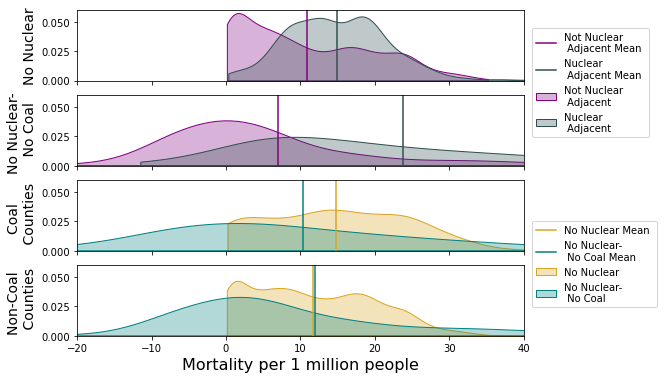

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex = True, figsize = [8,6], sharey = True)
#ax1 = fig.add_subplot(1,2,1)

x1 = (combined_df.loc[combined_df['nuclear_adjacent'] == 0]['Δmortality_PM_mean_nonuc_per1mil'])
x2 = (combined_df.loc[combined_df['nuclear_adjacent'] == 1]['Δmortality_PM_mean_nonuc_per1mil'])
colors = ['purple','darkslategrey']
label_opt = ['Not Nuclear \n Adjacent', 'Nuclear \n Adjacent']

for idx, x in enumerate([x1, x2]):
    sns.kdeplot(x, ax = ax1, shade = True, alpha = .3, color = colors[idx], cut = 0, label = label_opt[idx])
    ax1.axvline(x.mean(), 0,1, color = colors[idx], label = f'{label_opt[idx]} Mean ')
ax1.set_ylabel('No Nuclear', fontsize = 14)
ax1.legend(loc = [1.02,-.8])

x1 = (combined_df.loc[combined_df['nuclear_adjacent'] == 0]['Δmortality_PM_mean_nonuc_coal_per1mil'])
x2 = (combined_df.loc[combined_df['nuclear_adjacent'] == 1]['Δmortality_PM_mean_nonuc_coal_per1mil'])
label_opt = ['Not Nuclear \n Adjacent', 'Nuclear \n Adjacent']

for idx, x in enumerate([x1, x2]):
    sns.kdeplot(x, ax = ax2, shade = True, alpha = .3, color = colors[idx], cut = 0)
    ax2.axvline(x.mean(), 0,1, color = colors[idx])
ax2.set_ylabel('No Nuclear- \n No Coal', fontsize = 14)

x1 = (combined_df.loc[combined_df['coal_containing'] == 1]['Δmortality_PM_mean_nonuc_per1mil'])
x2 = (combined_df.loc[combined_df['coal_containing'] == 1]['Δmortality_PM_mean_nonuc_coal_per1mil'])
label_opt = ['No Nuclear', 'No Nuclear- \n No Coal']
colors = ['goldenrod','teal']
for idx, x in enumerate([x1, x2]):
    sns.kdeplot(x, ax = ax3, shade = True, alpha = .3, color = colors[idx], cut = 0, label = label_opt[idx])
    ax3.axvline(x.mean(), 0,1, color = colors[idx], label = f'{label_opt[idx]} Mean ')
ax3.set_ylabel('Coal \n Counties', fontsize = 14)
ax3.legend(loc = [1.02,-.8])
x1 = (combined_df.loc[combined_df['coal_containing'] == 0]['Δmortality_PM_mean_nonuc_per1mil'])
x2 = (combined_df.loc[combined_df['coal_containing'] == 0]['Δmortality_PM_mean_nonuc_coal_per1mil'])
label_opt = ['No Nuclear', 'No Nuclear-No Coal']

for idx, x in enumerate([x1, x2]):
    sns.kdeplot(x, ax = ax4, shade = True, alpha = .3, color = colors[idx], cut = 0)
    ax4.axvline(x.mean(), 0,1, color = colors[idx])
ax4.set_ylabel('Non-Coal \n Counties', fontsize = 14)
    
plt.xlabel('Mortality per 1 million people', fontsize = 16)
plt.xlim(-20,40)
plt.savefig('Figures/systems_analysis_coal_nuc.png', dpi = 300, bbox_inches = 'tight')

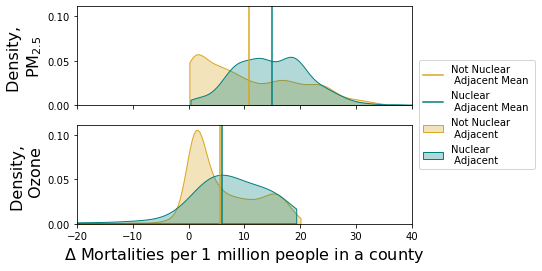

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [6,4], sharey = True)
#ax1 = fig.add_subplot(1,2,1)

x1 = (combined_df.loc[combined_df['nuclear_adjacent'] == 0]['Δmortality_PM_mean_nonuc_per1mil'])
x2 = (combined_df.loc[combined_df['nuclear_adjacent'] == 1]['Δmortality_PM_mean_nonuc_per1mil'])
colors = ['goldenrod','teal']
label_opt = ['Not Nuclear \n Adjacent', 'Nuclear \n Adjacent']

for idx, x in enumerate([x1, x2]):
    sns.kdeplot(x, ax = ax1, shade = True, alpha = .3, color = colors[idx], cut = 0, label = label_opt[idx])
    ax1.axvline(x.mean(), 0,1, color = colors[idx], label = f'{label_opt[idx]} Mean ')
ax1.set_ylabel('Density, \n'+ r'PM$_{2.5}$', fontsize = 16)
ax1.legend(loc = [1.02,-.65])

x1 = (combined_df.loc[combined_df['nuclear_adjacent'] == 0]['Δmortality_O3_mean_nonuc_per1mil'])
x2 = (combined_df.loc[combined_df['nuclear_adjacent'] == 1]['Δmortality_O3_mean_nonuc_per1mil'])
colors = ['goldenrod','teal']
label_opt = ['Not Nuclear \n Adjacent', 'Nuclear \n Adjacent']

for idx, x in enumerate([x1, x2]):
    sns.kdeplot(x, ax = ax2, shade = True, alpha = .3, cut = 0, color = colors[idx], label = label_opt[idx])
    ax2.axvline(x.mean(), 0,1, color = colors[idx], label = f'{label_opt[idx]} Mean ')
ax2.set_ylabel('Density, \n Ozone', fontsize = 16)

plt.xlabel(r'$\Delta$ Mortalities per 1 million people in a county', fontsize = 16)

plt.xlim(-20,40)
plt.savefig('Figures/systems_nonuc_poll_mort.png', dpi = 300, bbox_inches = 'tight')

## Maps of Different County Exposure by State

In [16]:
counties = geopandas.read_file('data/cb_2018_us_county_500k.shx')
counties = counties.rename(columns = {'NAME':'CountyName'})

states = geopandas.read_file('data/cb_2018_us_state_500k.shx')
states = states.rename(columns = {'NAME':'StateName'})

states['StateName'] = states['StateName'].str.lower()
counties['STATEFP'] = counties['STATEFP'].astype("string")

In [17]:
combined_df['State'] = census_df.groupby('County_State').first()['STNAME']

/tmp/ipykernel_2785202/1583385887.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2785202/1583385887.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


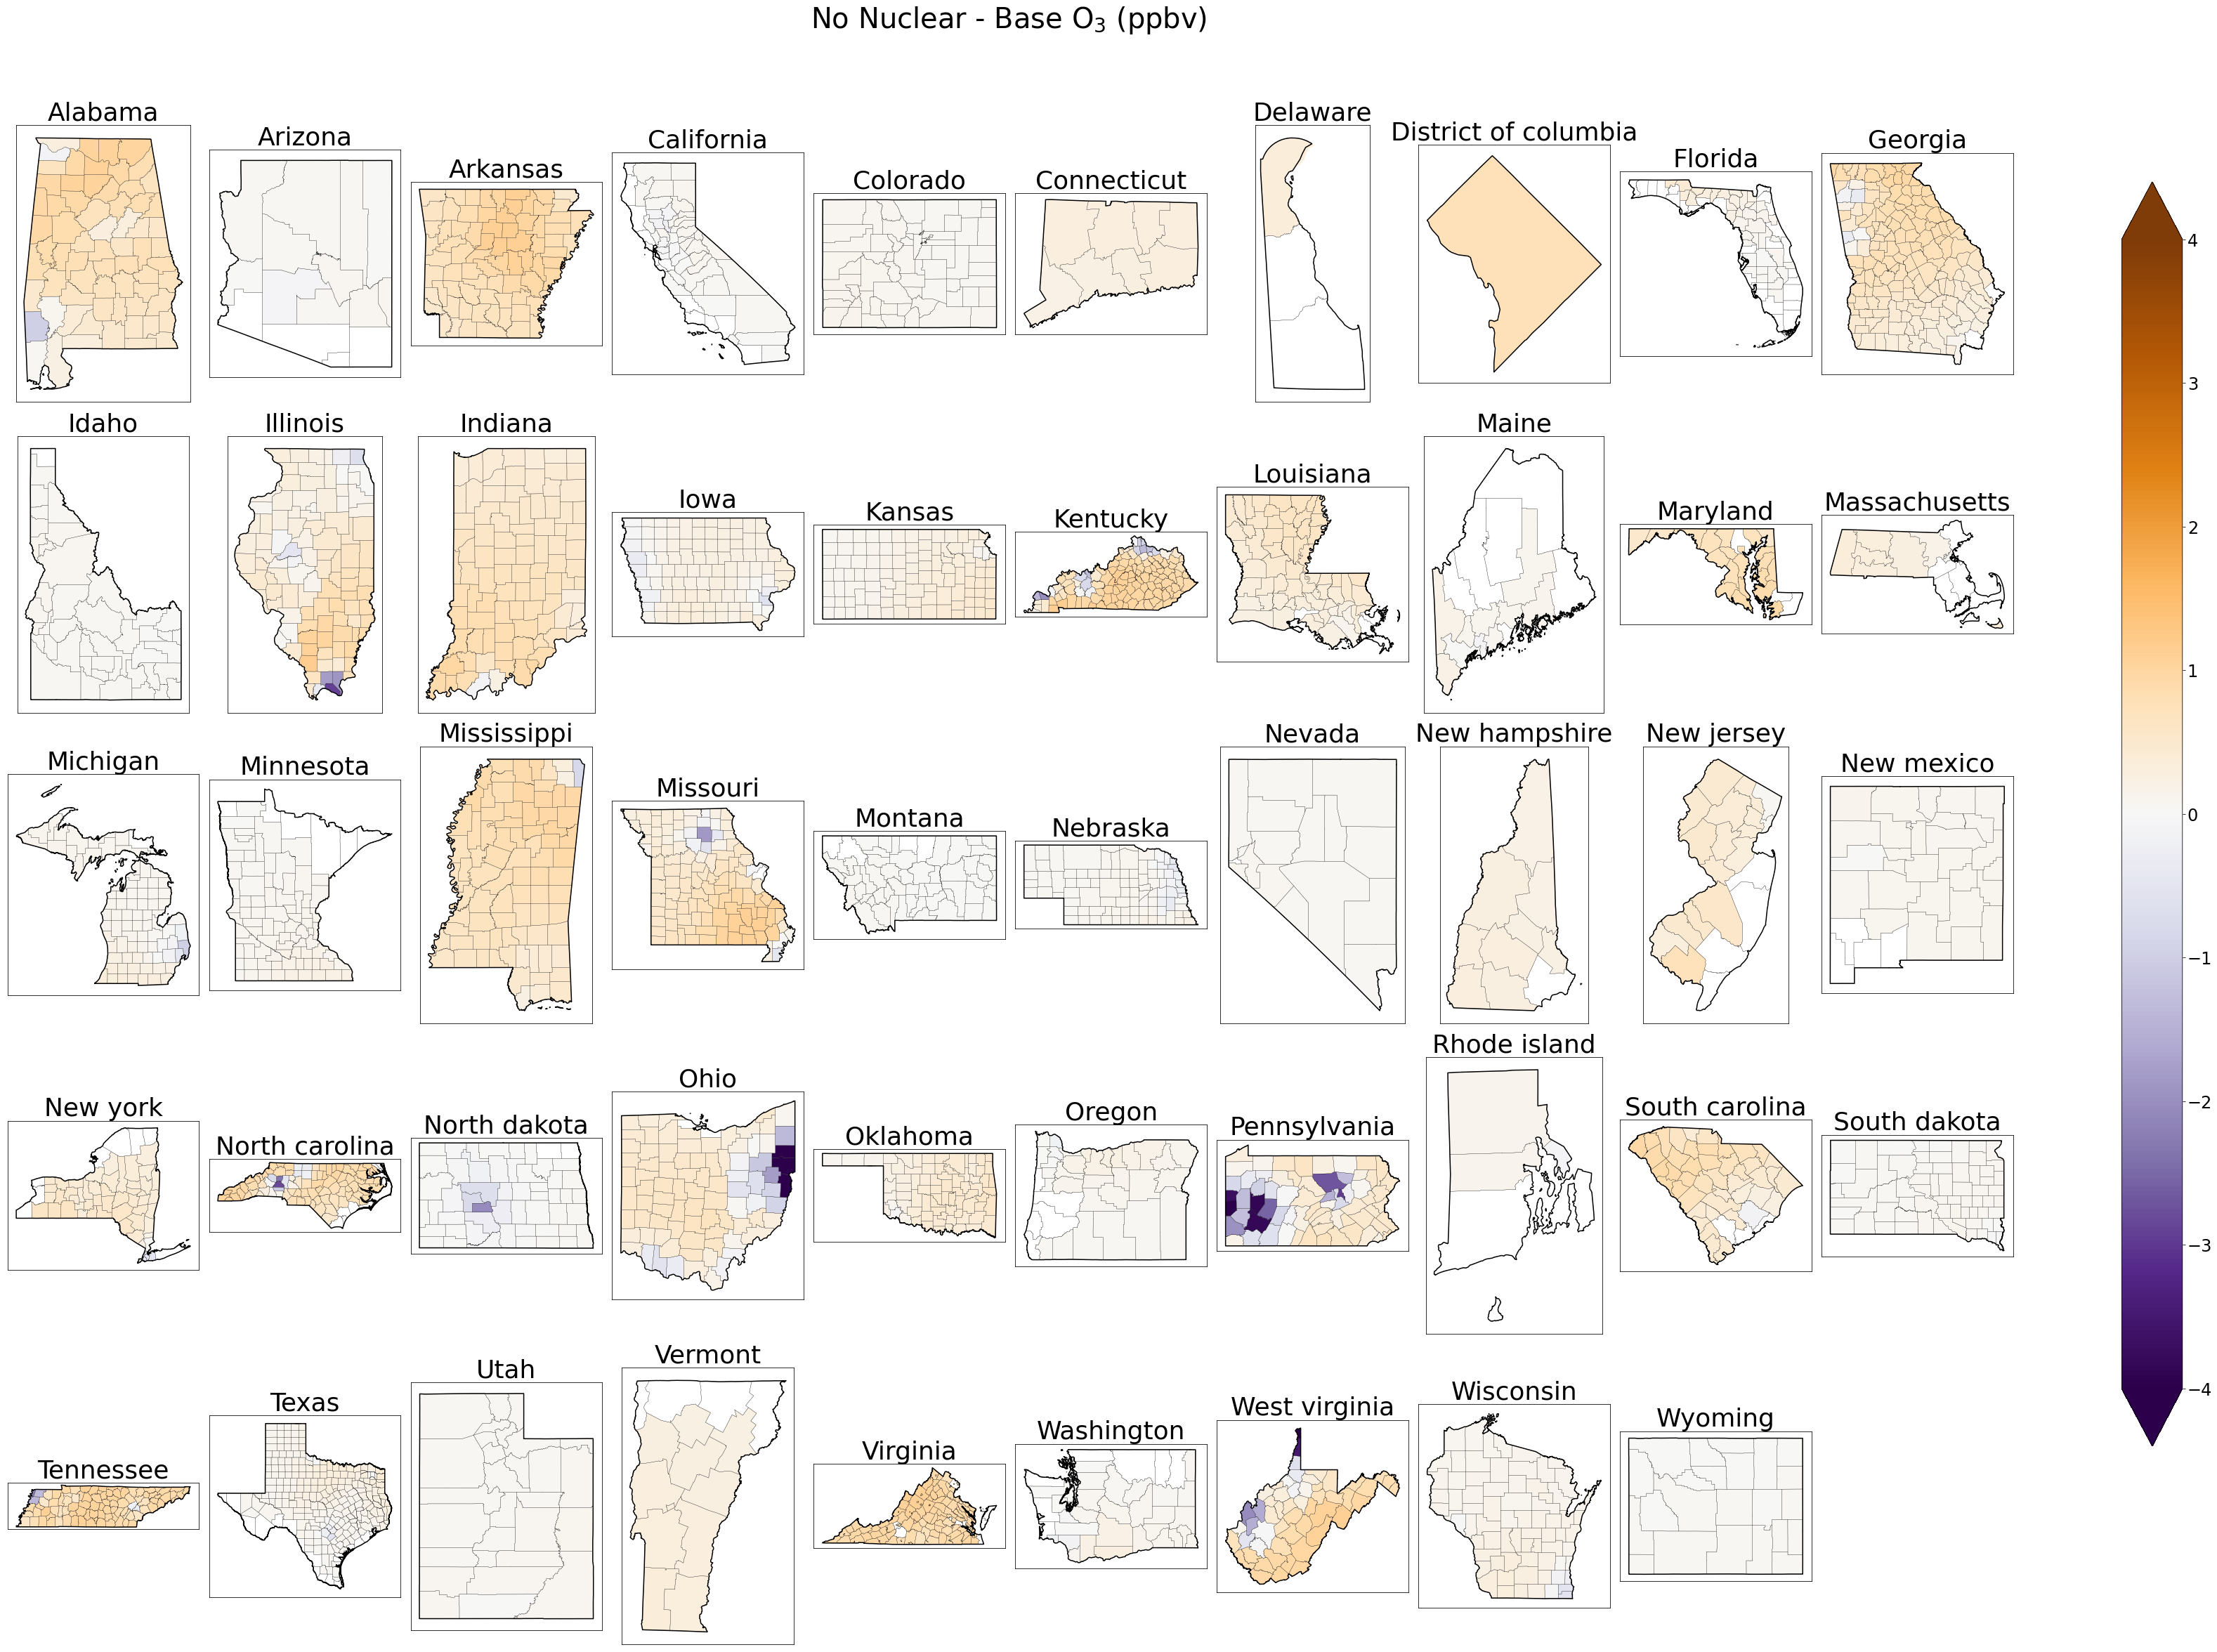

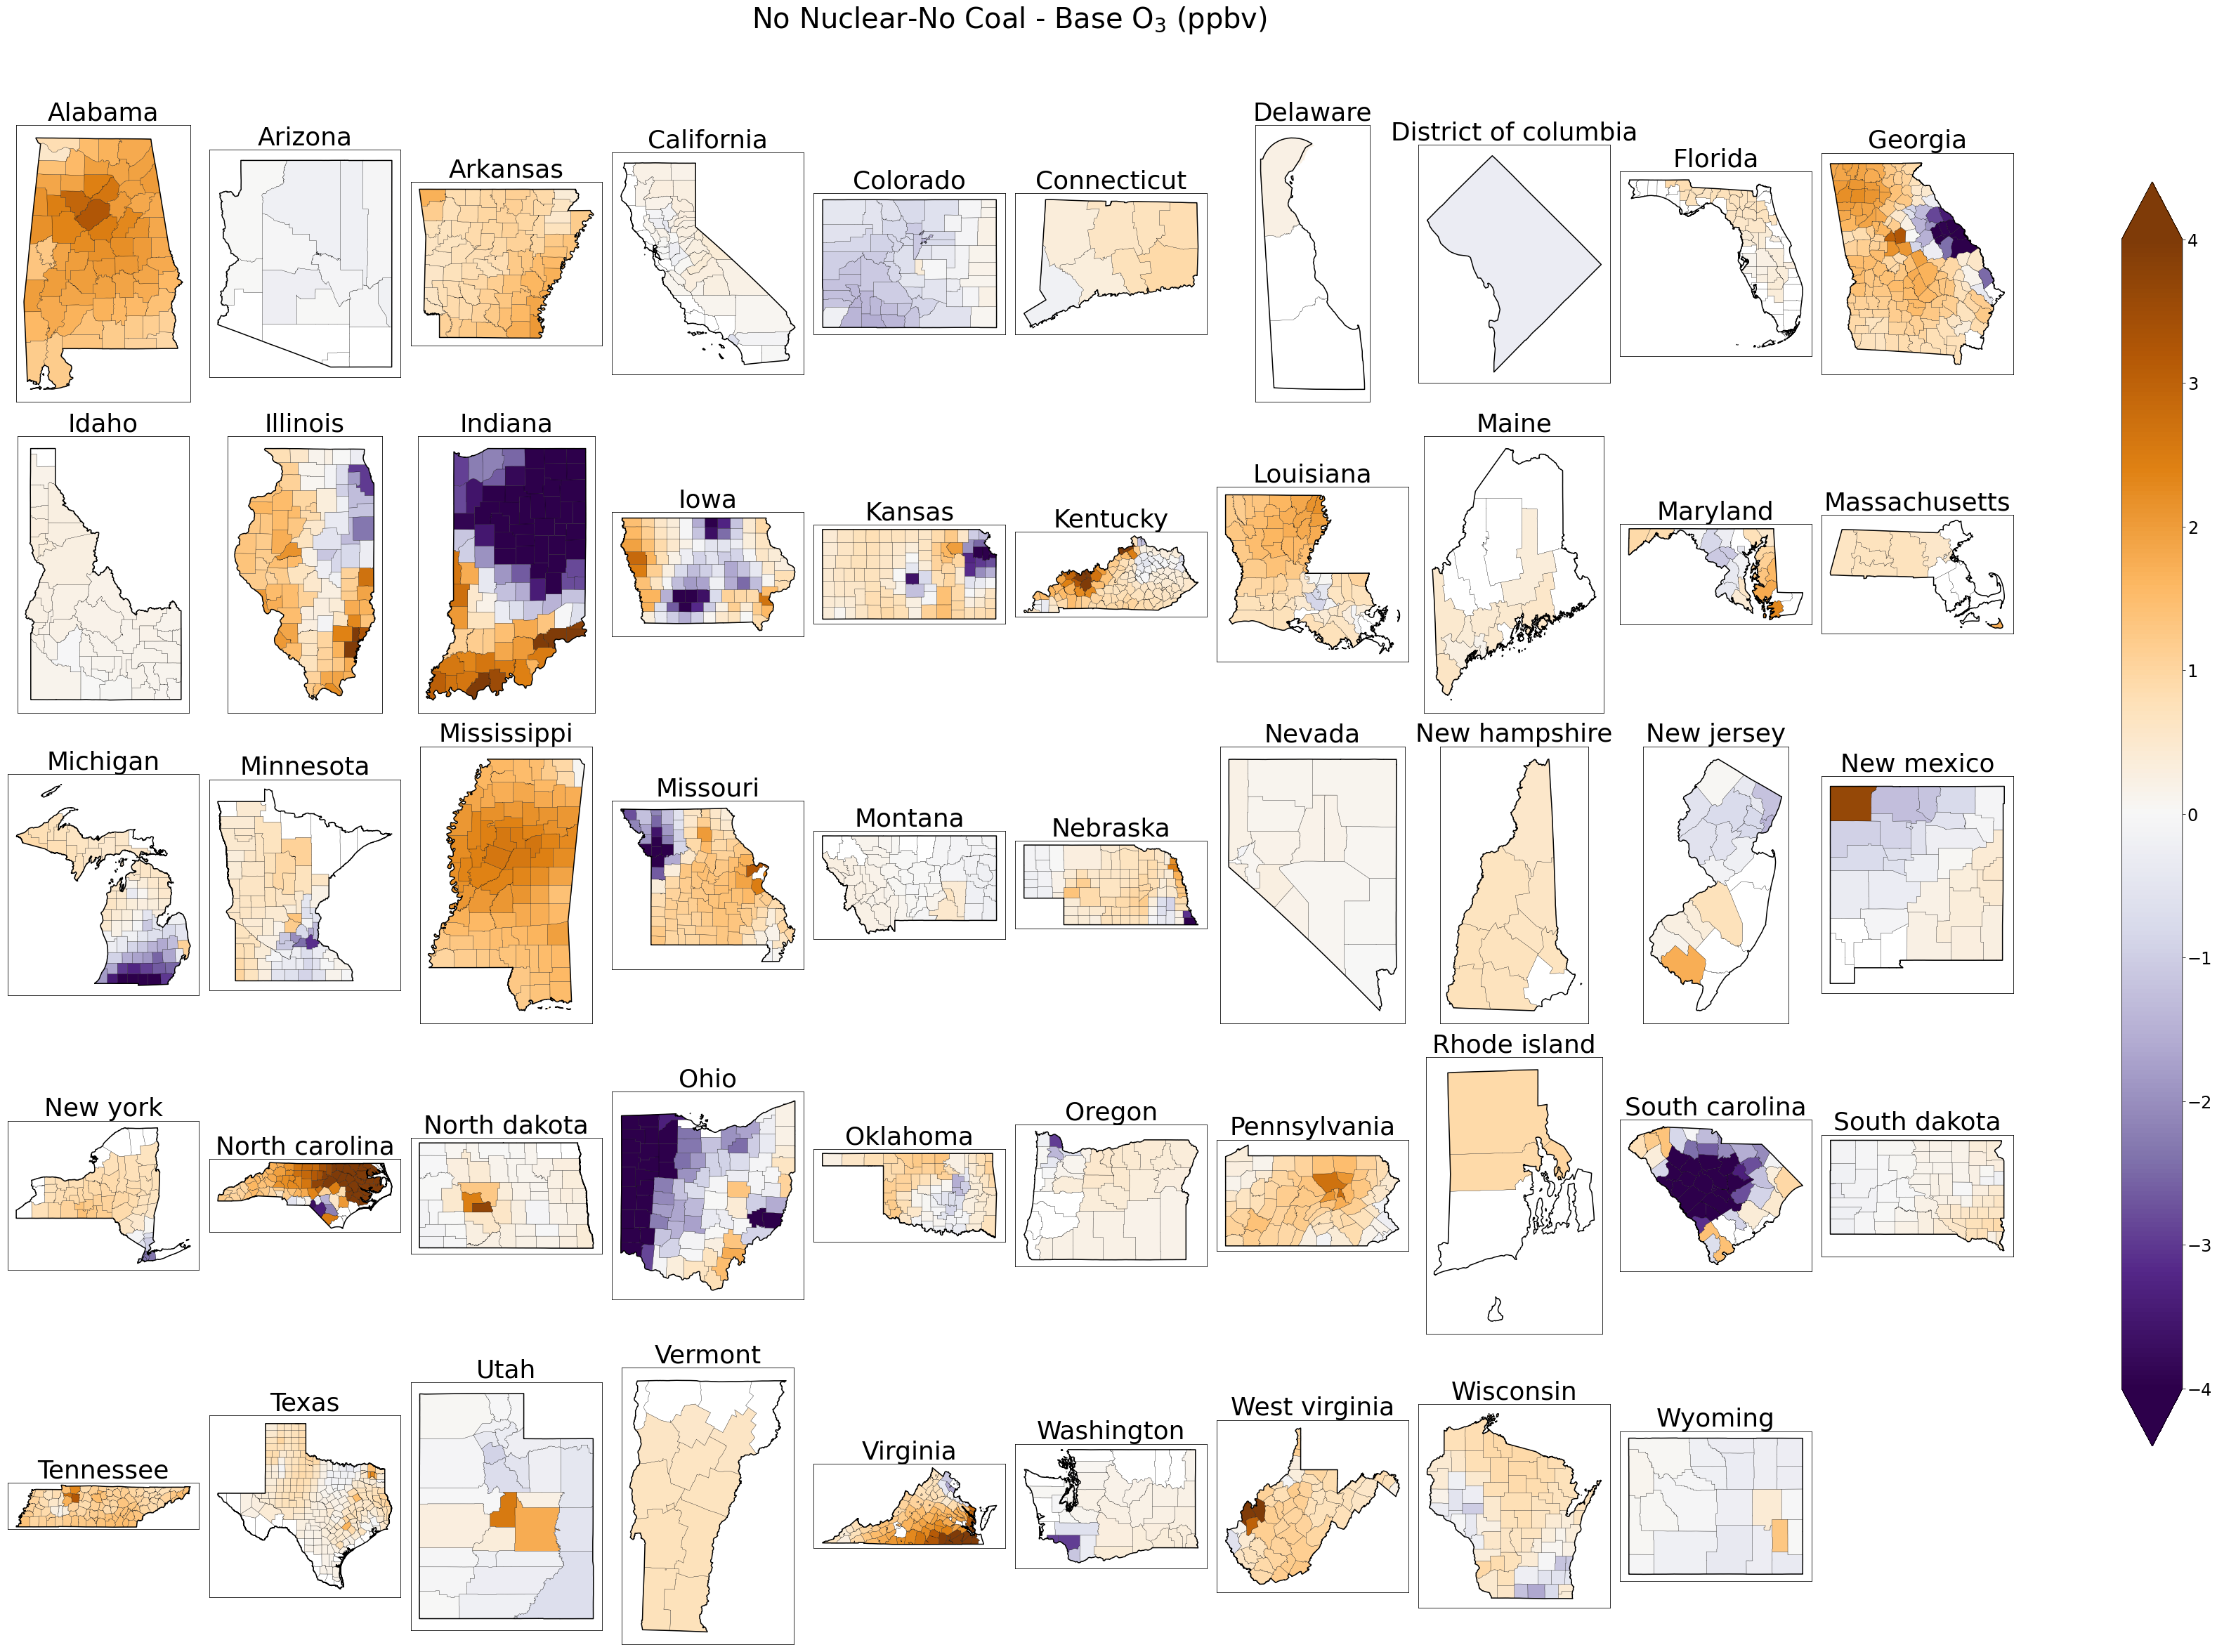

In [28]:
vmin = -4
vmax = 4
cmap = 'PuOr_r'
for idx, run in enumerate(['nonuc','nonuc_coal']):
    fig = plt.figure(figsize=[40,50])
    for idx_s, state in enumerate(np.unique(combined_df['State'])):
        ###OZONE###
        ax = fig.add_subplot(8,10,idx_s+1)
        q = combined_df.loc[combined_df['State'] == state].plot(ax = ax, column = f'O3_{run}', legend=False, 
                                                 vmin = vmin, vmax = vmax, 
                                                 cmap = cmap)
        statefp = states.loc[states['StateName'] == state]['STATEFP'].values[0]
        counties.loc[counties['STATEFP'] == statefp].boundary.plot(ax = ax, color = 'k', linewidth = .2)
        states.loc[states['StateName'] == state].boundary.plot(ax = ax, color = 'k',)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(state.capitalize(), fontsize = 36)
    # Add single colorbar
    cax = fig.add_axes([1.05, 0.45, 0.03, 0.5])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax = vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, extend = 'both')
    cbar.ax.tick_params(labelsize=24)
    
    if run == 'nonuc':
        plt.suptitle(r'No Nuclear - Base O$_3$ (ppbv)', y = 1.02, fontsize = 40)
    if run == 'nonuc_coal':
        plt.suptitle(r'No Nuclear-No Coal - Base O$_3$ (ppbv)', y = 1.02, fontsize = 40)  
    plt.tight_layout()
    plt.savefig(f'Figures/{run}_ozone_state_map.png', dpi = 150, bbox_inches = 'tight')


/tmp/ipykernel_2785202/1311859127.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2785202/1311859127.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


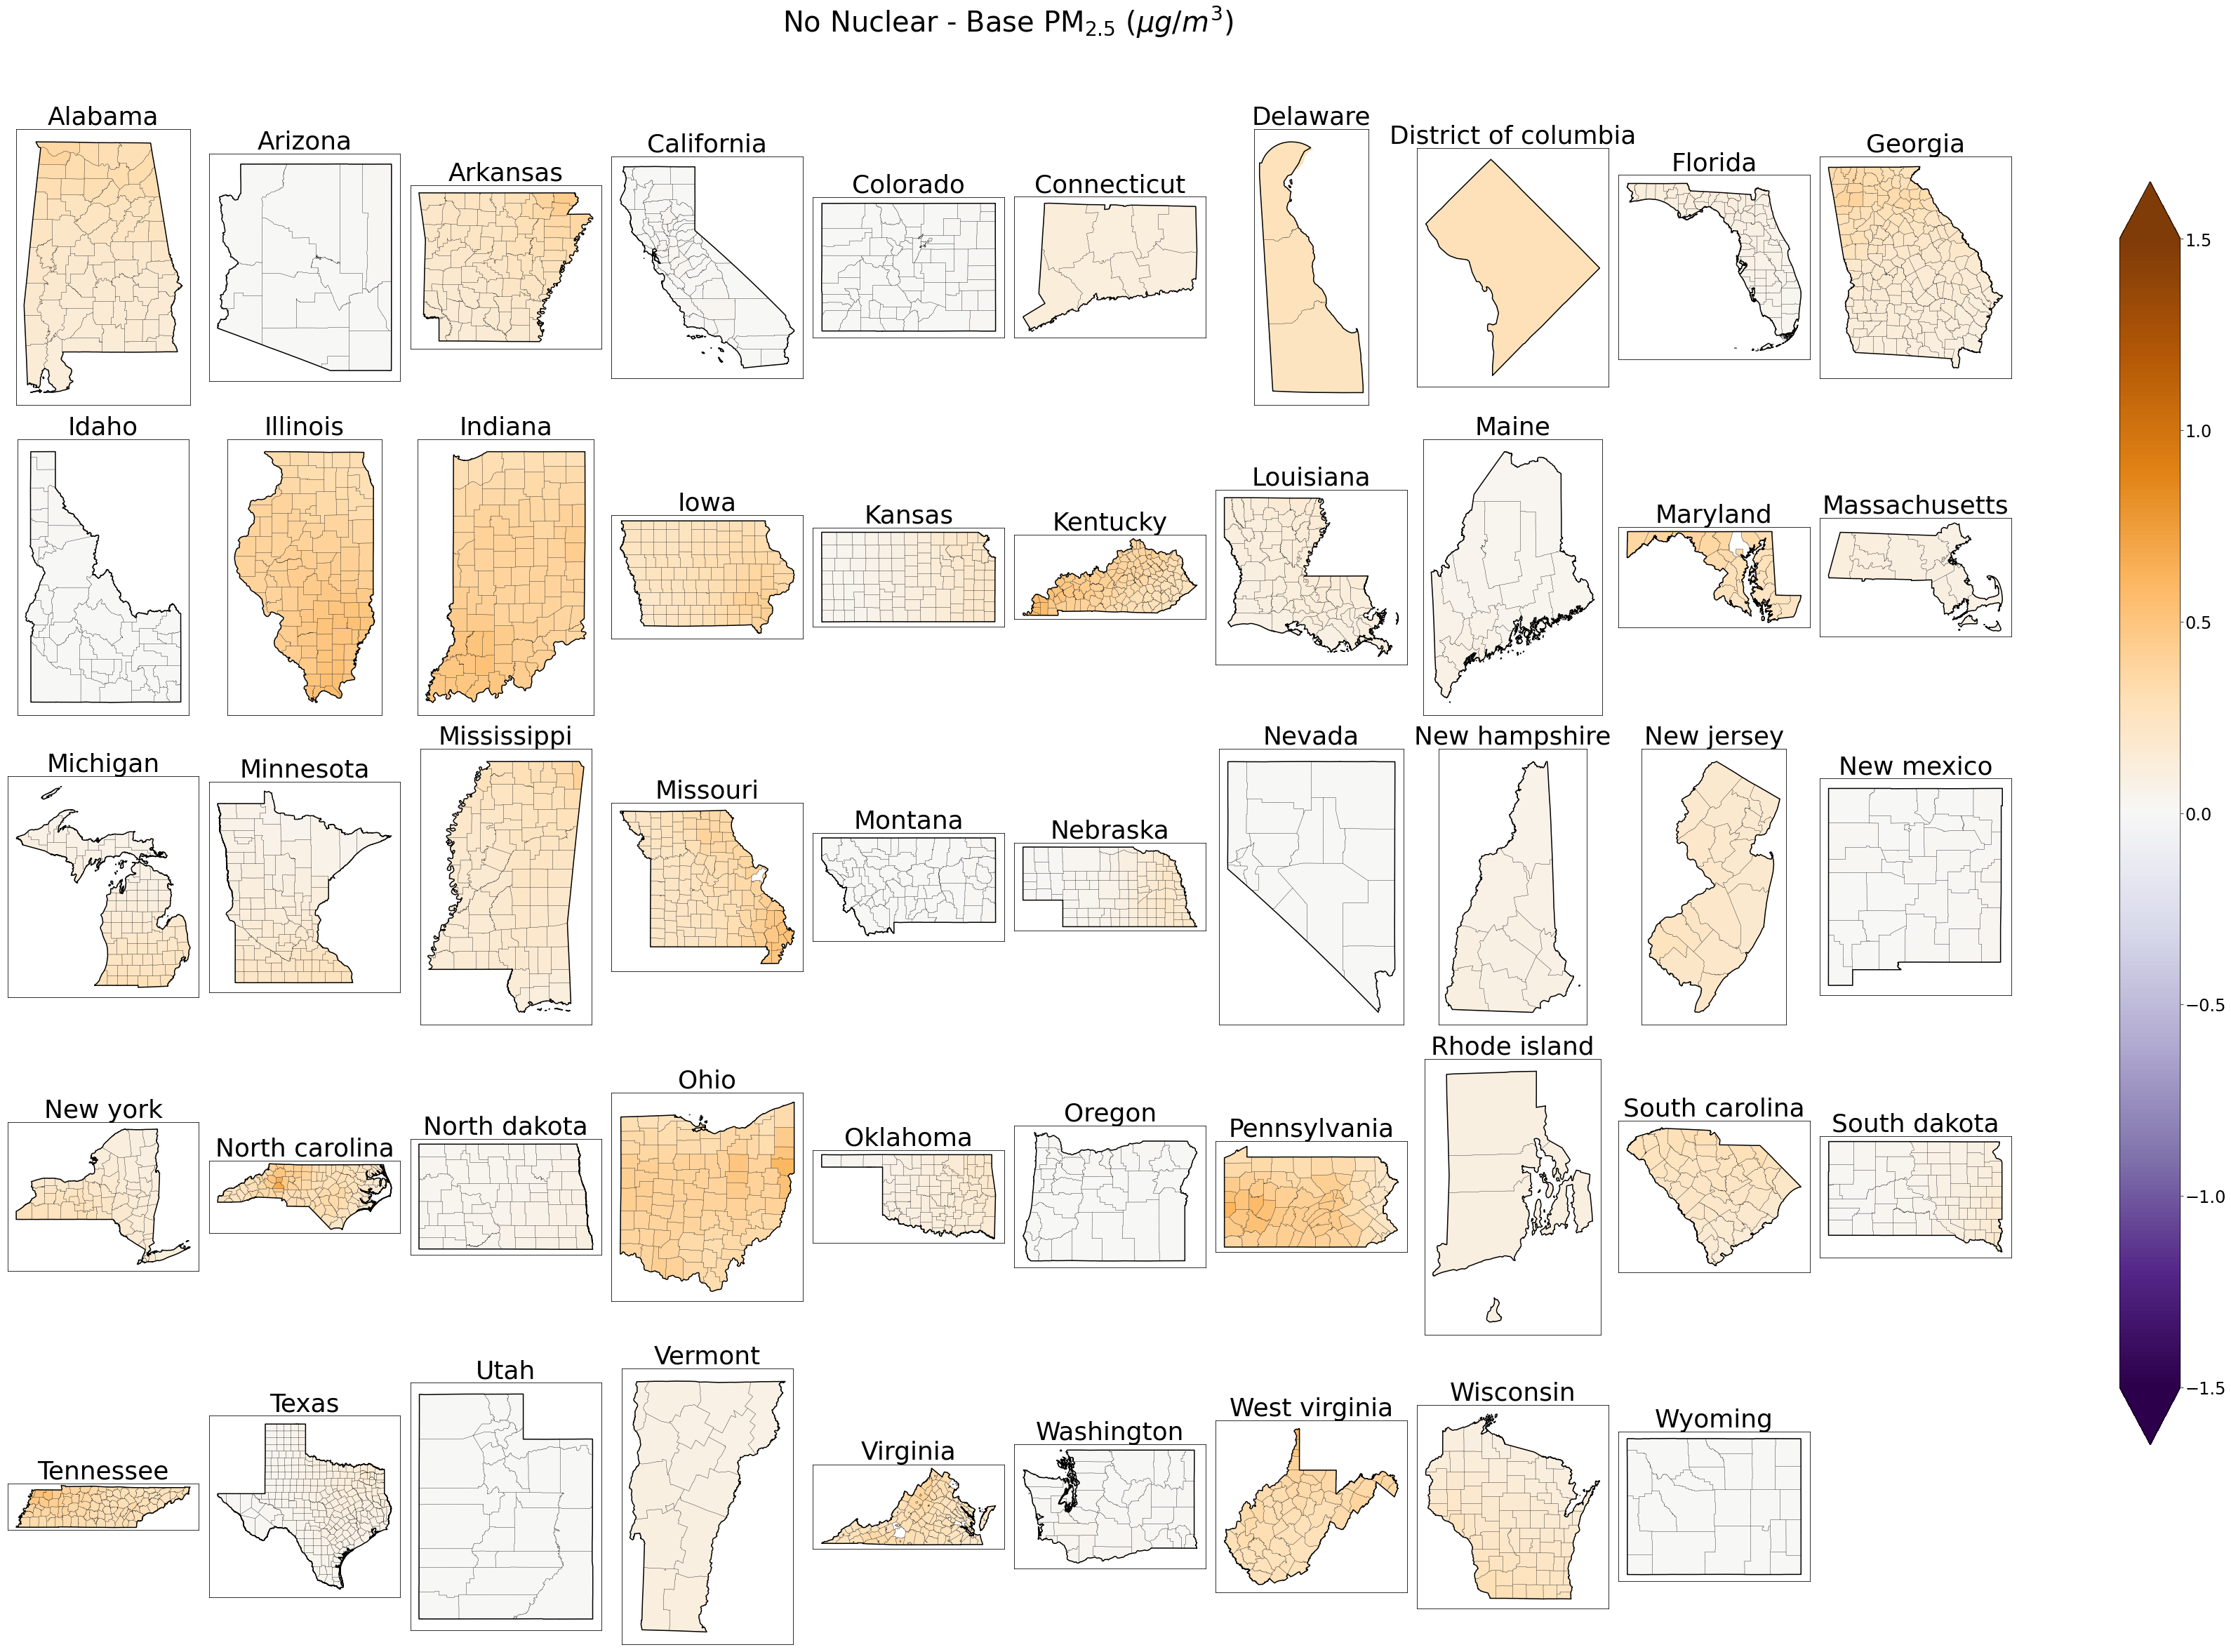

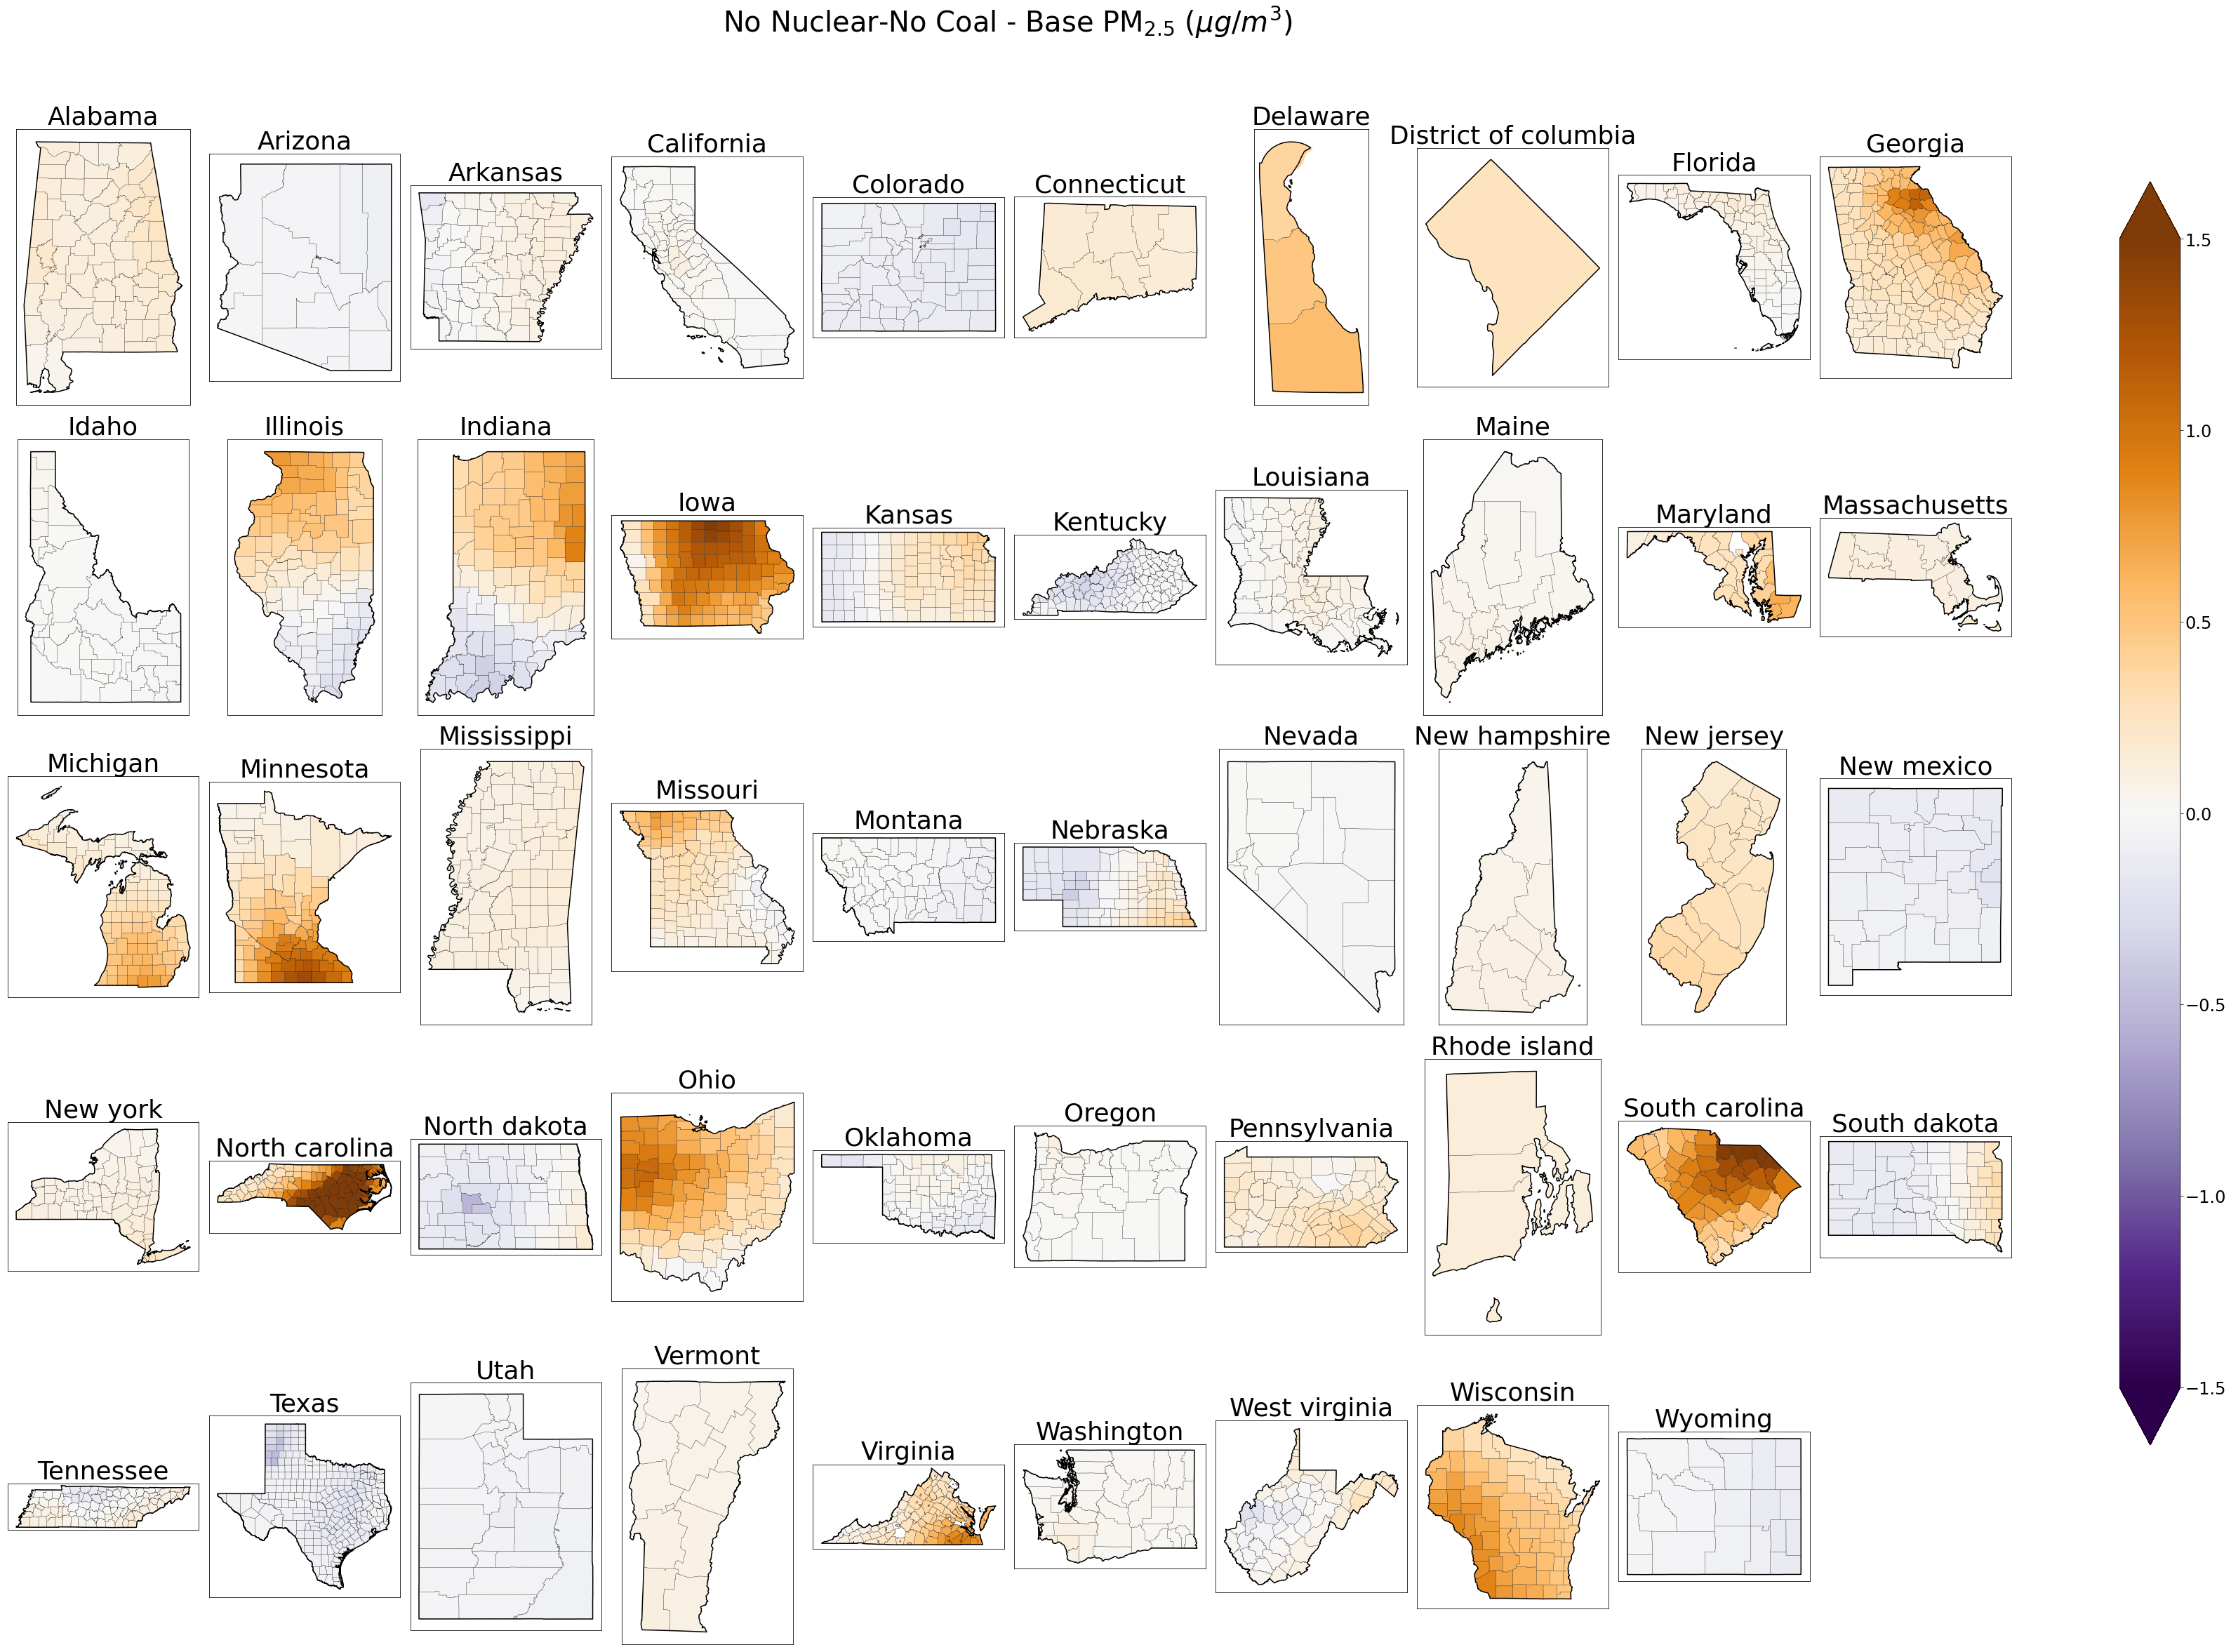

In [29]:
vmin = -1.5
vmax = 1.5
cmap = 'PuOr_r'
for idx, run in enumerate(['nonuc','nonuc_coal']):
    fig = plt.figure(figsize=[40,50])
    for idx_s, state in enumerate(np.unique(combined_df['State'])):
        ###PM###
        ax = fig.add_subplot(8,10,idx_s+1)
        q = combined_df.loc[combined_df['State'] == state].plot(ax = ax, column = f'PM25_{run}', legend=False, 
                                                 vmin = vmin, vmax = vmax,  
                                                 cmap = cmap)
        statefp = states.loc[states['StateName'] == state]['STATEFP'].values[0]
        counties.loc[counties['STATEFP'] == statefp].boundary.plot(ax = ax, color = 'k', linewidth = .2)
        states.loc[states['StateName'] == state].boundary.plot(ax = ax, color = 'k',)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(state.capitalize(), fontsize = 36)
        
    # Add single colorbar
    cax = fig.add_axes([1.05, 0.45, 0.03, 0.5])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax = vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax, extend = 'both')
    cbar.ax.tick_params(labelsize=24)
    
    if run == 'nonuc':
        plt.suptitle(r'No Nuclear - Base PM$_{2.5}$ ($\mu g/m^3$)', y = 1.02, fontsize = 40)
    if run == 'nonuc_coal':
        plt.suptitle(r'No Nuclear-No Coal - Base PM$_{2.5}$ ($\mu g/m^3$)', y = 1.02, fontsize = 40)  
    plt.tight_layout()
    plt.savefig(f'Figures/{run}_pm_state_map.png', dpi = 150, bbox_inches = 'tight')
